In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import csv
from os import listdir

## Load files

In [10]:
# path to directory containing all the solvers folders 
dir_run = '../results'

In [28]:
def get_best_result_df(best_result_file_path):
    history = []
    with open(best_result_file_path, 'r', newline='') as file:
        reader = csv.reader(file)
        counter = 0
        for row in reader:
            if counter == 1:
                params = row
            elif counter == 3:
                history = row
            elif counter == 5:
                configs = row
            counter += 1
    # D, AEdAO, PdD, Z, fitness
    D       = float(params[0])
    AEdAO   = float(params[1])
    PdD     = float(params[2])
    Z       = int(params[3]) if len(params[3]) == 1 else int(float(params[3]))
    fitness = float(params[6])
    # history    
    if len(history) > 0:
        history = [float(h) for h in history]
    # configs
    solver_name = configs[0]
    vs        = float(configs[1])
    n_pop       = int(configs[2])
    max_it      = int(configs[3])
    seed        = int(configs[4])
    
    if (solver_name == 'openaies' or solver_name == 'cmaes'):
        fitness = -fitness
    
    # create new entry in df
    new_data = {'D': D, 
                'AEdAO': AEdAO, 
                'PdD': PdD,
                'Z': int(Z),
                'Brake Power': fitness,
                'Seed': seed,
                'Algorithm': solver_name,
                'VS': vs,
                'Npop': n_pop,
                'maxIt': max_it}
    return new_data

In [51]:
data = {'D': [], 'AEdAO': [], 'PdD': [], 'Z': [], 'Brake Power': [], 'Seed': [], 'Algorithm': [], 'VS': [], 'Npop':[], 'maxIt':[]}
df_results = pd.DataFrame(data)

# enter in the folders until reach the files with the executions
for solver_run in listdir(dir_run):
    solver_run = dir_run+'/'+solver_run
    # dir's created by the multiple_run_solver
    for solver_vs in listdir(solver_run):
        solver_vs = solver_run+'/'+solver_vs
        for dir_seed in listdir(solver_vs):
            
            if (dir_seed == 'best_configuration.csv'):
                continue
            
            dir_seed = solver_vs+'/'+dir_seed
            # get the file with best results for that seed execution
            
            best_result_file = [filename for filename in listdir(dir_seed) if 'best_results' in filename]
            if len(best_result_file) > 0:
                best_result_file = best_result_file[0]
                best_result_file = dir_seed+'/'+best_result_file
                new_data = get_best_result_df(best_result_file)
                df_results = pd.concat([df_results, pd.DataFrame(new_data, index=[0])], ignore_index=True)
            else:
                print('not able to find best result file in', dir_seed)


In [52]:
# remove not used 'pop size', 'max generations'
df_results = df_results.drop(['Npop', 'maxIt'], axis=1)

In [53]:
# rename Algorithm col
solver_renames = {'cmaes':    'CMA-ES',
                  'openaies': 'OpenAI-ES',
                  'DE':       'Replicated DE',
                  'DE_mod':   'Proposed DE'
                 }

df_results['Algorithm'] = df_results['Algorithm'].replace(solver_renames)

In [8]:
len(df_results)

140

In [15]:
df_results

,D,AEdAO,PdD,Z,Brake Power,Seed,Algorithm,VS
0,0.799987,0.633664,0.672028,5.0,81.413788,0.0,CMA-ES,7.0
1,0.799999,0.646034,0.677715,5.0,81.441559,1.0,CMA-ES,7.0
2,0.799930,0.644941,0.674038,5.0,81.448787,2.0,CMA-ES,7.0
3,0.799982,0.708452,0.721333,6.0,81.822126,3.0,CMA-ES,7.0
4,0.799685,0.638271,0.672324,5.0,81.453434,4.0,CMA-ES,7.0
...,...,...,...,...,...,...,...,...
135,0.800000,0.911744,0.665244,6.0,169.949451,5.0,OpenAI-ES,8.5
136,0.800000,1.003300,0.726210,6.0,171.671147,6.0,OpenAI-ES,8.5
137,0.800000,1.050000,0.737450,6.0,172.982277,7.0,OpenAI-ES,8.5
138,0.800000,0.965046,0.689676,6.0,170.904031,8.0,OpenAI-ES,8.5


show info

In [54]:
df_results.groupby(['VS', 'Algorithm'])['Brake Power'].mean()

VS   Algorithm    
7.0  CMA-ES            81.475936
     OpenAI-ES         82.008907
     Proposed DE       81.466281
     Replicated DE     81.551321
7.5  CMA-ES           106.278583
     OpenAI-ES        107.285511
     Proposed DE      106.294594
     Replicated DE    106.597808
8.0  CMA-ES           135.609221
     OpenAI-ES        136.560257
     Proposed DE      135.934097
8.5  CMA-ES           169.627690
     OpenAI-ES        171.067343
     Proposed DE      170.393346
Name: Brake Power, dtype: float64

Compare

In [55]:
# Find the index of the row with the minimal fitness value
min_fitness_index = df_results.groupby(['VS'])['Brake Power'].idxmin()

# Get the row with the minimal fitness value
min_fitness_row = df_results.loc[min_fitness_index]

min_fitness_row

,D,AEdAO,PdD,Z,Brake Power,Seed,Algorithm,VS
6,0.799999,0.632382,0.666291,5.0,81.413114,6.0,CMA-ES,7.0
13,0.799971,0.707176,0.667861,5.0,106.211652,3.0,CMA-ES,7.5
23,0.799999,0.787442,0.661302,5.0,135.580055,3.0,CMA-ES,8.0
38,0.800000,0.891859,0.670561,6.0,169.441851,8.0,CMA-ES,8.5


In [56]:
lower_values = df_results.groupby(['VS', 'Algorithm'])['Brake Power'].min()
print(lower_values)

VS   Algorithm    
7.0  CMA-ES            81.413114
     OpenAI-ES         81.434983
     Proposed DE       81.416083
     Replicated DE     81.432608
7.5  CMA-ES           106.211652
     OpenAI-ES        106.481633
     Proposed DE      106.219254
     Replicated DE    106.294816
8.0  CMA-ES           135.580055
     OpenAI-ES        135.624596
     Proposed DE      135.602710
8.5  CMA-ES           169.441851
     OpenAI-ES        169.455708
     Proposed DE      169.532497
Name: Brake Power, dtype: float64


In [57]:
df_vs_7_0 = df_results[df_results['VS'] == 7]
df_vs_7_5 = df_results[df_results['VS'] == 7.5]
df_vs_8_0 = df_results[df_results['VS'] == 8]
df_vs_8_5 = df_results[df_results['VS'] == 8.5]

## Tables

In [58]:
def get_min_row(data):
    index_min_PB = data.groupby('Algorithm')['Brake Power'].idxmin()
    # Select original rows using index
    rows_min_PB = data.loc[index_min_PB]
    return rows_min_PB

def get_min(data):
    min_PB = data.groupby('Algorithm')['Brake Power'].min()
    return min_PB

In [59]:
vs = 8.5

In [60]:
df_results[df_results['VS'] == vs].groupby('Algorithm')['Brake Power'].min()

Algorithm
CMA-ES         169.441851
OpenAI-ES      169.455708
Proposed DE    169.532497
Name: Brake Power, dtype: float64

In [61]:
print('VS Algortihm D AE/AO P/D Z')
for r in get_min_row(data = df_vs_7_0).to_numpy():
    d    = r[0]
    aedao= r[1]
    pdd  = r[2]
    z    = r[3]
    pb   = r[4]
    algor= r[6]
    vs   = r[7]
    z = int(z)
    print(f'{algor} & {d:.3f} & {aedao:.3f} & {pdd:.3f} & {z}' + " \\\\" )

VS Algortihm D AE/AO P/D Z
CMA-ES & 0.800 & 0.632 & 0.666 & 5 \\
OpenAI-ES & 0.800 & 0.633 & 0.660 & 5 \\
Proposed DE & 0.800 & 0.630 & 0.665 & 5 \\
Replicated DE & 0.800 & 0.626 & 0.655 & 5 \\


In [62]:
print('VS Algortihm D AE/AO P/D Z')
for r in get_min_row(data = df_vs_7_5).to_numpy():
    d    = r[0]
    aedao= r[1]
    pdd  = r[2]
    z    = r[3]
    pb   = r[4]
    algor= r[6]
    vs   = r[7]
    z = int(z)
    print(f'{algor} & {d:.3f} & {aedao:.3f} & {pdd:.3f} & {z}' + " \\\\" )

VS Algortihm D AE/AO P/D Z
CMA-ES & 0.800 & 0.707 & 0.668 & 5 \\
OpenAI-ES & 0.800 & 0.743 & 0.705 & 5 \\
Proposed DE & 0.800 & 0.709 & 0.670 & 5 \\
Replicated DE & 0.800 & 0.722 & 0.684 & 5 \\


In [63]:
print('VS Algortihm D AE/AO P/D Z')
for r in get_min_row(data = df_vs_8_0).to_numpy():
    d    = r[0]
    aedao= r[1]
    pdd  = r[2]
    z    = r[3]
    pb   = r[4]
    algor= r[6]
    vs   = r[7]
    z = int(z)
    print(f'{algor} & {d:.3f} & {aedao:.3f} & {pdd:.3f} & {z}' + " \\\\" )

VS Algortihm D AE/AO P/D Z
CMA-ES & 0.800 & 0.787 & 0.661 & 5 \\
OpenAI-ES & 0.800 & 0.798 & 0.665 & 6 \\
Proposed DE & 0.800 & 0.806 & 0.675 & 6 \\


In [64]:
print('VS Algortihm D AE/AO P/D Z')
for r in get_min_row(data = df_vs_8_5).to_numpy():
    d    = r[0]
    aedao= r[1]
    pdd  = r[2]
    z    = r[3]
    pb   = r[4]
    algor= r[6]
    vs   = r[7]
    z = int(z)
    print(f'{algor} & {d:.3f} & {aedao:.3f} & {pdd:.3f} & {z}' + " \\\\" )

VS Algortihm D AE/AO P/D Z
CMA-ES & 0.800 & 0.892 & 0.671 & 6 \\
OpenAI-ES & 0.800 & 0.893 & 0.672 & 6 \\
Proposed DE & 0.800 & 0.899 & 0.675 & 6 \\


In [65]:
df_results[(df_results['VS'] == 7.5) & (df_results['Algorithm'] == 'Replicated DE')]

,D,AEdAO,PdD,Z,Brake Power,Seed,Algorithm,VS
50,0.8,0.791450,0.688724,6.0,106.824585,0.0,Replicated DE,7.5
51,0.8,0.745159,0.701431,5.0,106.481413,1.0,Replicated DE,7.5
52,0.8,0.684896,0.626173,5.0,106.370843,2.0,Replicated DE,7.5
53,0.8,0.735937,0.704851,5.0,106.429708,3.0,Replicated DE,7.5
54,0.8,0.795469,0.699079,5.0,106.936514,4.0,Replicated DE,7.5
55,0.8,0.767456,0.729379,6.0,106.586432,5.0,Replicated DE,7.5
56,0.8,0.742103,0.673651,6.0,106.614348,6.0,Replicated DE,7.5
57,0.8,0.752171,0.646442,5.0,106.755206,7.0,Replicated DE,7.5
58,0.8,0.743303,0.666116,6.0,106.684215,8.0,Replicated DE,7.5
59,0.8,0.722278,0.683577,5.0,106.294816,9.0,Replicated DE,7.5


## Graphs

In [66]:
def create_img(data, order, save=False, name='img'):
    fig, ax = plt.subplots()

    sns.boxplot(y="Brake Power",
                x = "Algorithm",
                hue = 'Algorithm',
                data=data,
                order=order
                )

    sns.set_style("whitegrid")
    sns.set(rc={'figure.figsize':(12,9)})
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=15)
    title_text = "VS = "
    for v in data['VS'].unique():
        title_text += str(v)
    plt.title(title_text, fontsize=15)
    plt.xlabel('Algorithm',  fontsize=16)
    plt.ylabel('Brake Power',fontsize=18)

    if save:
        plt.tight_layout()
        plt.savefig(name+".pdf", dpi=300)

In [17]:
save = False

In [ ]:
create_img(data = df_vs_7_0,
           order=['Replicated DE', 'Proposed DE', 'CMA-ES', 'OpenAI-ES'],
           save=save,
           name='boxplot_7_0' )

In [ ]:
create_img(data = df_vs_7_5,
           order=['Replicated DE', 'Proposed DE', 'CMA-ES', 'OpenAI-ES'],
           save=save,
           name='boxplot_7_5' )

In [ ]:
create_img(data = df_vs_8_0,
           order=['Replicated DE', 'Proposed DE', 'CMA-ES', 'OpenAI-ES'],
           save=save,
           name='boxplot_8_0' )

In [ ]:
create_img(data = df_vs_8_5,
           order=['Replicated DE', 'Proposed DE', 'CMA-ES', 'OpenAI-ES'],
           save=save,
           name='boxplot_8_5' )

## Double graphs

In [72]:
rename_dict = {'CMA-ES': 'CMA-ES',
               'OpenAI-ES': 'OpenAI-ES',
               'Replicated DE': 'DE\nReplicated',
               'Proposed DE': 'DE\nProposed'
              }

custom_order = {
    'DE\nReplicated': 1,
    'DE\nProposed':   2,
    'CMA-ES':         3,
    'OpenAI-ES':      4
}

In [73]:
font_size = 16

def multiple_boxplot(vs_values, save=False, only_put_1_legend=False):
    # Create subplots with a shared x-axis
    fig, ax = plt.subplots(1, len(vs_values), sharey='col', figsize=(11, 7))

    for i, vs in enumerate(vs_values):
        df_temp = df_results[df_results['VS'] == vs]
        # rename 
        df_temp.loc[:,'Algorithm'] = df_temp['Algorithm'].map(rename_dict)
        # Get unique values and sort them based on the custom order
        unique_values = sorted(df_temp['Algorithm'].unique(), key=lambda x: custom_order[x])

        # create the box plot
        sns.boxplot(y="Brake Power", 
                    x = "Algorithm",
                    hue = 'Algorithm',
                    order=unique_values,
#                         palette="hls", # Colors
                    data=df_temp, ax=ax[i])  

        # Set the title for the subplot
        ax[i].set_title(f'VS = {vs}',   fontsize=font_size)
        ax[i].tick_params(axis='both', labelsize=font_size) 
        # Set labels for x and y axes
        ax[i].set_xlabel('Algorithm',   fontsize=font_size)
        ax[i].set_ylabel('Brake Power', fontsize=font_size)

        # ylim
        minmax = df_temp['Brake Power'].agg(['min', 'max']).to_list()
        ax[i].set_ylim(minmax[0]*0.999, minmax[1]*1.001) 
        
        if only_put_1_legend:
            # only put 1 legend
            if i == 1:
        #         ax[i].legend(loc='upper right')
                legend = ax[i].legend(loc='upper left', bbox_to_anchor=(1, 1))
            else:
                ax[i].legend([],[], frameon=False)

    # Adjust spacing between subplots
    plt.tight_layout()
    
    # save
    if save:
        name_f  = 'boxplot'
        # speed
        name_f += '_' + "and".join([str(v) for v in vs_values])
        name_f  = name_f.replace('.','_')
        # file type
        name_f += '.pdf'
        plt.savefig(name_f, bbox_inches='tight')
        print('saved', name_f)

    # Show the plot
    plt.show()

In [74]:
save=True

saved boxplot_7_0and7_5.pdf


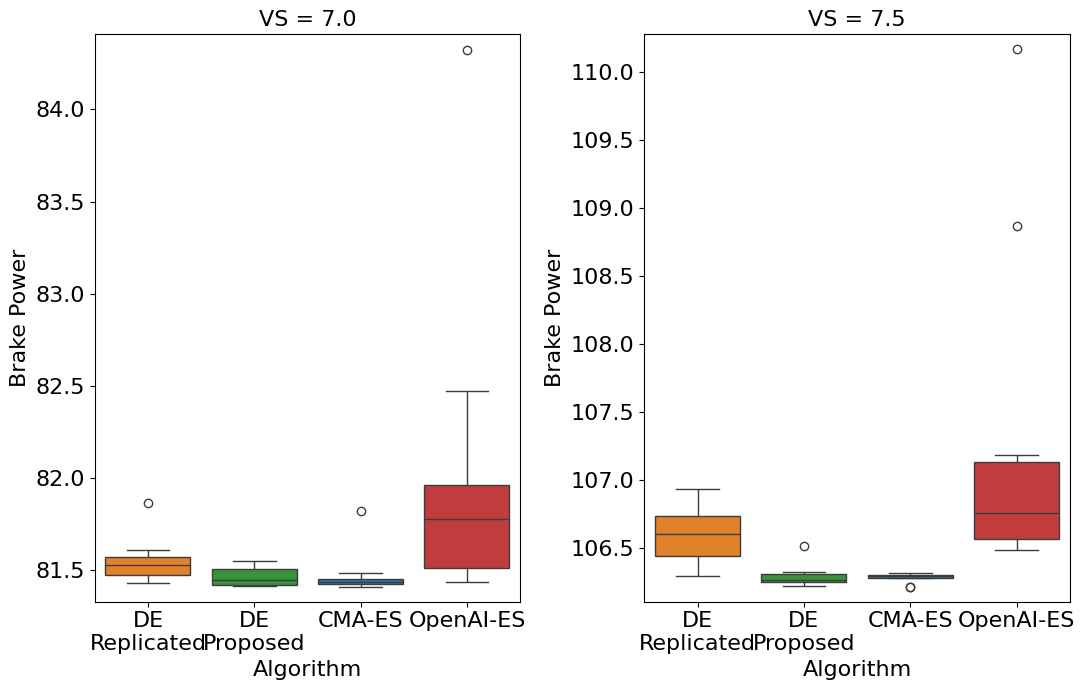

In [75]:
multiple_boxplot([7.0, 7.5], save=save)

saved boxplot_8_0and8_5.pdf


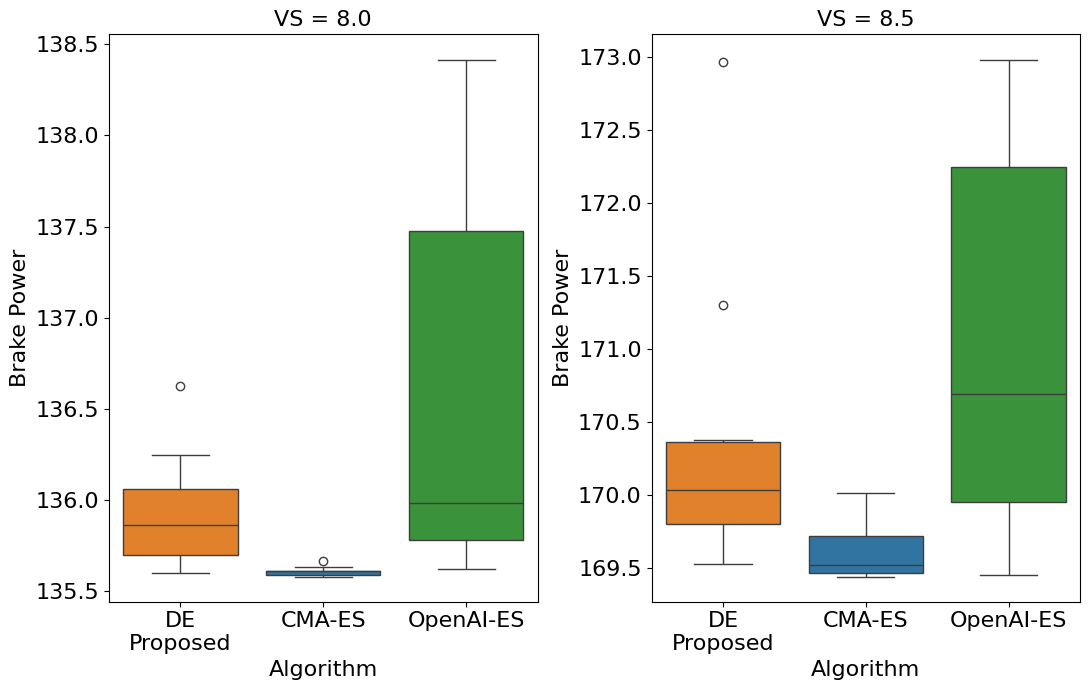

In [76]:
multiple_boxplot([8.0, 8.5], save=save)